In [192]:
%matplotlib widget
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from _utils import ObjectTracker, Parabolic3D, Exp3D

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
TAKE_FOLDER = 'TAKE_2'

In [194]:
greenLower = (18, 86, 6)
greenUpper = (74, 255, 255)

In [195]:
if False:
    tracker = ObjectTracker(greenUpper, greenLower, TAKE_FOLDER)
    # tracker.set_angle()
    df = tracker.obj_tracker()
    df.to_csv(f'location_{TAKE_FOLDER.lower()}.csv', index=False)

# Transfer to Spatial Coordinate

Todo:

- Image calibration

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy

In [197]:
TAKE = 1
MODEL = 'exp3D' # exp3D or parabolic3D
# MODEL = 'parabolic3D'

- The frame rate is 25 fps.
- The height for both left and right camera is 110 cm and the horizontal
- distance between left and right cameras is 70 cm.
- Focal length: 6.3 mm
- CCD size: 1/2.5 in (1 cm), 5.7 mm*4.29 mm
- Image resolution: 640 * 480 pixel

In [198]:
FPS = 25 # 1/25 sec per frame
CL_LOCATION = (1.1, -0.35, 0) # meter (x: height, y: width, z: depth)
CR_LOCATION = (1.1, 0.35, 0) # meter
FOCAL_LEN = 6.3*1e-3 # meter
SENSOR_SIZE = (5.7*1e-3, 4.29*1e-3) # meter (W, H)
IMG_RESOLUTION = (640, 480) # px (W, H)

In [199]:
def get_XYZ(df, **kwargs):
    (xl, yl) = (df.loc[df['camera'] == 'L', 'x'].values[0], df.loc[df['camera'] == 'L', 'y'].values[0]) # px (W, H)
    (xr, yr) = (df.loc[df['camera'] == 'R', 'x'].values[0], df.loc[df['camera'] == 'R', 'y'].values[0])
    
    # transfer px to meter and shift to center
    sensor_size = kwargs['sensor_size']
    img_res = kwargs['img_res']
    (xc, yc) = (img_res[0]//2, img_res[1]//2)
    (xl, yl) = (xl - xc, - yl + yc)
    (xr, yr) = (xr- xc, - yr + yc)
    (xl, yl) = (xl*sensor_size[0]/img_res[0], yl*sensor_size[1]/img_res[1])
    (xr, yr) = (xr*sensor_size[0]/img_res[0], yr*sensor_size[1]/img_res[1])
    
    
    # print(f'take_{ df["take"].values[0] } frame_{ df["frame_num"].values[0] }')
    # print((xl, yl)) 
    # print((xr, yr))

    cl_loc = kwargs['cl_loc']; cr_loc = kwargs['cr_loc'] # (H, W, D)
    beta = np.abs(cl_loc[1]-cr_loc[1])

    ZZ = kwargs['focal_len'] * beta / (xl - xr)
    XX = beta * yr / (xl - xr)   # x in image is different from real coordinate (x, y exchange)
    YY = beta * xr / (xl - xr)
    (XX, YY, ZZ) = (XX+1.1, YY+0.35, ZZ)
    df['XX'] = XX
    df['YY'] = YY
    df['ZZ'] = ZZ
    return df

model: Exp3D
TAKE_1, Landing Point:[0.   0.03 6.88], vf: [-5.37091177 -0.03915184  9.9466407 ], |vf|: 11.304153539906673
g=[-1.06148313e+01  0.00000000e+00  1.94339558e-11]


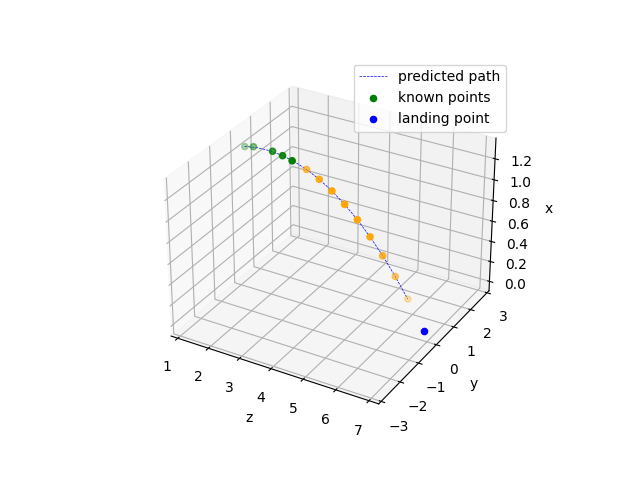

In [200]:
df = pd.read_csv(f'location_take_{TAKE}.csv')

frame_nums = df['frame_num'].unique()
frame_nums.sort()
cameras = df['camera'].unique()
cameras.sort()

tracked = []
for f in frame_nums:
    df_slice = df[df['frame_num'] == f].copy()
    params = {
        'cl_loc': CL_LOCATION,
        'cr_loc': CR_LOCATION,
        'focal_len': FOCAL_LEN,
        'sensor_size': SENSOR_SIZE,
        'img_res': IMG_RESOLUTION,
    }

    df_slice = get_XYZ(df_slice, **params)
    (XX, YY, ZZ) = (df_slice['XX'].values[0], df_slice['YY'].values[0], df_slice['ZZ'].values[0])
    # print((XX, YY, ZZ))
    tracked.append([XX, YY, ZZ])

tracked = np.array(tracked)

#### fitting ####
model = Parabolic3D() if MODEL == 'parabolic3D' else Exp3D()

model.fit(tracked)
weights = model.get_params()
# print(weights)

#### calculate distance error ####
dist_err = model.calc_dist_error(tracked)
# print('mean distance error: ', dist_err)


# print(weights)

#### find t when x = 0 (landing points) ####

if MODEL == 'parabolic3D':
    # => find root of w[0] + w[1]*t + w[2]*t^2 = 0
    r1 = (-weights[1]+np.sqrt(weights[1] ** 2 - 4 * weights[2] * weights[0]))/(weights[2]*2)
    r2 = (-weights[1]-np.sqrt(weights[1] ** 2 - 4 * weights[2] * weights[0]))/(weights[2]*2)
    t_landing = r1 if r1 >= 0 else r2
    t_landing = np.array([t_landing])
    point_landing = model.predict(t_landing)
    point_landing = point_landing[:,0]

else:
    # => find root of w[0]*t - w[1]*np.exp((t/w[1])) + w[2] = 0
    t_landing_1 = 14.282
    t_landing_2 = 17.241
    t_landing = np.array([t_landing_1]) if TAKE == 1 else np.array([t_landing_2])
    point_landing = model.predict(t_landing)
    point_landing = point_landing[:,0]

#### find the initial velocity vi ####
dt = 0.001 # frame
init_point = model.predict(np.array([0]))[:,0]
a = model.predict(np.array([dt]))[:,0]

dx = a - init_point
vi = dx/(dt/FPS)
vi_mag = np.sqrt(vi[0]**2+vi[1]**2+vi[2]**2)

#### find the final velocity vf ####
dt = 0.001 # frame
a = model.predict(t_landing+dt)[:,0]
dx = a - point_landing
vf = dx/(dt/FPS)
vf_mag = np.sqrt(vf[0]**2+vf[1]**2+vf[2]**2)

#### print answer ####
print(f'model: {model.__class__.__name__}')
print(f'TAKE_{TAKE}, Landing Point:{np.round(point_landing,2)}, vf: {vf}, |vf|: {vf_mag}')
print(f"g={(vf-vi)/(t_landing/FPS)}")

#### plot the estimate path ####
t_est = np.arange(0, int(t_landing), 1)
xyz_est = model.predict(t_est).reshape(3, -1)

#### visualize ####
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot(xyz_est[2, :], xyz_est[1, :], xyz_est[0, :], color="blue", label="predicted path", linestyle='--', linewidth='0.5')
ax.scatter(xyz_est[2, 5:], xyz_est[1, 5:], xyz_est[0, 5:], color="orange")
ax.scatter(tracked[:,2], tracked[:,1], tracked[:,0],color='green', label="known points")
ax.scatter(point_landing[2], point_landing[1], point_landing[0], color="blue", label="landing point")
ax.set_xlabel('z')
ax.set_ylabel('y')
ax.set_zlabel('x')
ax.set_ylim(-3,3)
plt.legend()
plt.show()